# A Monte Carlo Option Pricer

This notebook introduces the vectorize and CUDA Python features in Numba to speedup a monte carlo option pricer.



## A Numpy Implementation

The following is a NumPy implementatation of a simple monte carlo pricer.
It consists of two functions.
The `mc_numpy` function is the entry point of the pricer.
The entire simulation is divided into small time step `dt`.
The `step_numpy` function simulates the next batch of prices for each `dt`.

In [10]:
from __future__ import print_function
%matplotlib inline
import numpy as np                         # numpy namespace
from timeit import default_timer as timer  # for timing
from matplotlib import pyplot              # for plotting
import math
import sys

if sys.version_info[0] == 2:
    range = xrange

In [11]:
def step_numpy(dt, prices, c0, c1, noises):
    return prices * np.exp(c0 * dt + c1 * noises)

def mc_numpy(paths, dt, interest, volatility):
    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * np.sqrt(dt)

    for j in range(1, paths.shape[1]):   # for each time step
        prices = paths[:, j - 1]          # last prices
        # gaussian noises for simulation
        noises = np.random.normal(0., 1., prices.size)
        # simulate
        paths[:, j] = step_numpy(dt, prices, c0, c1, noises)

### Configurations

In [12]:
# stock parameter

StockPrice = 20.83
StrikePrice = 21.50
Volatility = 0.021
InterestRate = 0.20
Maturity = 5. / 12.

# monte-carlo parameter 

NumPath = 3000000
NumStep = 100

# plotting
MAX_PATH_IN_PLOT = 50

### Driver

The driver measures the performance of the given pricer and plots the simulation paths.

In [13]:
def driver(pricer, do_plot=False):
    paths = np.zeros((NumPath, NumStep + 1), order='F')
    paths[:, 0] = StockPrice
    DT = Maturity / NumStep

    ts = timer()
    pricer(paths, DT, InterestRate, Volatility)
    te = timer()
    elapsed = te - ts

    ST = paths[:, -1]
    PaidOff = np.maximum(paths[:, -1] - StrikePrice, 0)
    print('Result')
    fmt = '%20s: %s'
    print(fmt % ('stock price', np.mean(ST)))
    print(fmt % ('standard error', np.std(ST) / np.sqrt(NumPath)))
    print(fmt % ('paid off', np.mean(PaidOff)))
    optionprice = np.mean(PaidOff) * np.exp(-InterestRate * Maturity)
    print(fmt % ('option price', optionprice))

    print('Performance')
    NumCompute = NumPath * NumStep
    print(fmt % ('Mstep/second', '%.2f' % (NumCompute / elapsed / 1e6)))
    print(fmt % ('time elapsed', '%.3fs' % (te - ts)))

    if do_plot:
        pathct = min(NumPath, MAX_PATH_IN_PLOT)
        for i in range(pathct):
            pyplot.plot(paths[i])
        print('Plotting %d/%d paths' % (pathct, NumPath))
        pyplot.show()
    return elapsed

### Result

Result
         stock price: 22.6403600091
      standard error: 0.000177304848873
            paid off: 1.14036511011
        option price: 1.0491865502
Performance
        Mstep/second: 16.19
        time elapsed: 18.535s
Plotting 50/3000000 paths


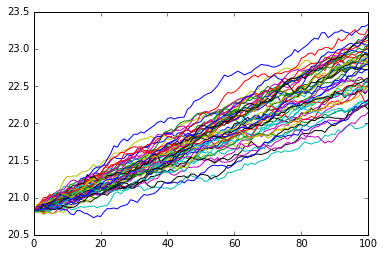

In [14]:
numpy_time = driver(mc_numpy, do_plot=True)

## Basic Vectorize

The vectorize decorator compiles a scalar function into a Numpy ufunc-like object for operation on arrays.
The decorator must be provided with a list of possible signatures.
The `step_cpuvec` takes 5 double arrays and return a double array.

In [15]:
from numba import vectorize

@vectorize(['f8(f8, f8, f8, f8, f8)'])
def step_cpuvec(last, dt, c0, c1, noise):
    return last * math.exp(c0 * dt + c1 * noise)

def mc_cpuvec(paths, dt, interest, volatility):
    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * np.sqrt(dt)

    for j in range(1, paths.shape[1]):
        prices = paths[:, j - 1]
        noises = np.random.normal(0., 1., prices.size)
        paths[:, j] = step_cpuvec(prices, dt, c0, c1, noises)

Result
         stock price: 22.6402659309
      standard error: 0.000177074556935
            paid off: 1.14027043995
        option price: 1.04909944945
Performance
        Mstep/second: 17.47
        time elapsed: 17.172s
Plotting 50/3000000 paths


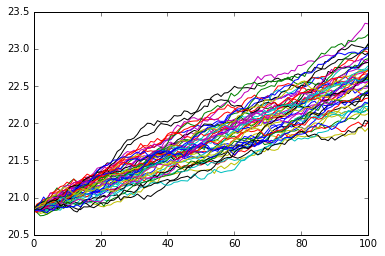

In [16]:
cpuvec_time = driver(mc_cpuvec, do_plot=True)

## Parallel Vectorize

By setting the target to `parallel`, the vectorize decorator produces a multithread implementation.

In [17]:
@vectorize(['f8(f8, f8, f8, f8, f8)'], target='parallel')
def step_parallel(last, dt, c0, c1, noise):
    return last * math.exp(c0 * dt + c1 * noise)

def mc_parallel(paths, dt, interest, volatility):
    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * np.sqrt(dt)

    for j in range(1, paths.shape[1]):
        prices = paths[:, j - 1]
        noises = np.random.normal(0., 1., prices.size)
        paths[:, j] = step_parallel(prices, dt, c0, c1, noises)

Result
         stock price: 22.6402851186
      standard error: 0.000177196074635
            paid off: 1.14029008558
        option price: 1.0491175243
Performance
        Mstep/second: 19.34
        time elapsed: 15.511s
Plotting 50/3000000 paths


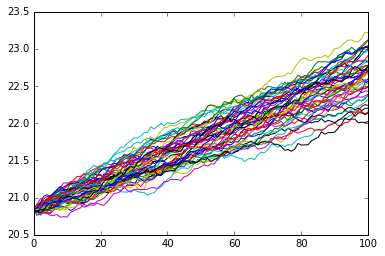

In [18]:
parallel_time = driver(mc_parallel, do_plot=True)

## CUDA Vectorize

To take advantage of the CUDA GPU, user can simply set the target to `cuda`.  
There are no different other than the target keyword argument.


In [19]:
@vectorize(['f8(f8, f8, f8, f8, f8)'], target='cuda')
def step_gpuvec(last, dt, c0, c1, noise):
    return last * math.exp(c0 * dt + c1 * noise)

def mc_gpuvec(paths, dt, interest, volatility):
    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * np.sqrt(dt)

    for j in range(1, paths.shape[1]):
        prices = paths[:, j - 1]
        noises = np.random.normal(0., 1., prices.size)
        paths[:, j] = step_gpuvec(prices, dt, c0, c1, noises)

Result
         stock price: 22.6400842998
      standard error: 0.00017727346627
            paid off: 1.14008870544
        option price: 1.04893224562
Performance
        Mstep/second: 22.18
        time elapsed: 13.525s
Plotting 50/3000000 paths


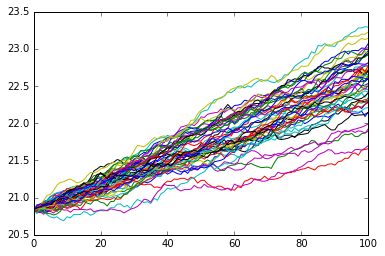

In [20]:
gpuvec_time = driver(mc_gpuvec, do_plot=True)

In the above simple CUDA vectorize example, the speedup is not significant due to the memory transfer overhead.  Since the kernel has relatively low compute intensity, explicit management of memory transfer would give a significant speedup.

## CUDA JIT

This implementation uses the CUDA JIT feature with explicit memory transfer and asynchronous kernel call.  A cuRAND random number generator is used instead of the NumPy implementation.

In [21]:
from numba import cuda, jit
from accelerate.cuda.rand import PRNG

@jit('void(double[:], double[:], double, double, double, double[:])', target='gpu')
def step_cuda(last, paths, dt, c0, c1, normdist):
    i = cuda.grid(1)
    if i >= paths.shape[0]:
        return
    noise = normdist[i]
    paths[i] = last[i] * math.exp(c0 * dt + c1 * noise)

def mc_cuda(paths, dt, interest, volatility):
    n = paths.shape[0]

    blksz = cuda.get_current_device().MAX_THREADS_PER_BLOCK
    gridsz = int(math.ceil(float(n) / blksz))

    # instantiate a CUDA stream for queueing async CUDA cmds
    stream = cuda.stream()
    # instantiate a cuRAND PRNG
    prng = PRNG(PRNG.MRG32K3A, stream=stream)

    # Allocate device side array
    d_normdist = cuda.device_array(n, dtype=np.double, stream=stream)
    
    c0 = interest - 0.5 * volatility ** 2
    c1 = volatility * math.sqrt(dt)

    # configure the kernel
    # similar to CUDA-C: step_cuda<<<gridsz, blksz, 0, stream>>>
    step_cfg = step_cuda[gridsz, blksz, stream]
    
    # transfer the initial prices
    d_last = cuda.to_device(paths[:, 0], stream=stream)
    for j in range(1, paths.shape[1]):
        # call cuRAND to populate d_normdist with gaussian noises
        prng.normal(d_normdist, mean=0, sigma=1)
        # setup memory for new prices
        # device_array_like is like empty_like for GPU
        d_paths = cuda.device_array_like(paths[:, j], stream=stream)
        # invoke step kernel asynchronously
        step_cfg(d_last, d_paths, dt, c0, c1, d_normdist)
        # transfer memory back to the host
        d_paths.copy_to_host(paths[:, j], stream=stream)
        d_last = d_paths
    # wait for all GPU work to complete
    stream.synchronize()

Result
         stock price: 22.6397789491
      standard error: 0.000177324589149
            paid off: 1.13978420099
        option price: 1.04865208801
Performance
        Mstep/second: 243.02
        time elapsed: 1.234s
Plotting 50/3000000 paths


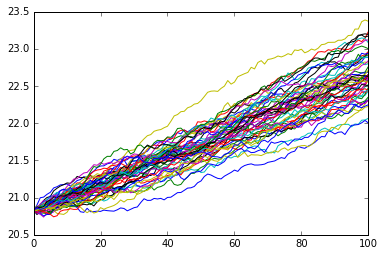

In [22]:
cuda_time = driver(mc_cuda, do_plot=True)

## Performance Comparision


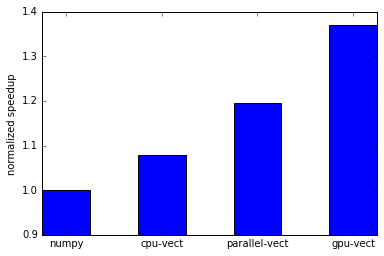

In [23]:
def perf_plot(rawdata, xlabels):
    data = [numpy_time / x for x in rawdata]
    idx = np.arange(len(data))
    fig = pyplot.figure()
    width = 0.5
    ax = fig.add_subplot(111)
    ax.bar(idx, data, width)
    ax.set_ylabel('normalized speedup')
    ax.set_xticks(idx + width / 2)
    ax.set_xticklabels(xlabels)
    ax.set_ylim(0.9)

perf_plot([numpy_time, cpuvec_time, parallel_time, gpuvec_time], 
          ['numpy', 'cpu-vect', 'parallel-vect', 'gpu-vect'])

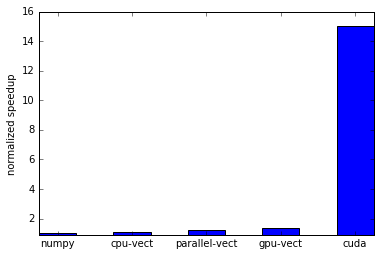

In [24]:
perf_plot([numpy_time, cpuvec_time, parallel_time, gpuvec_time, cuda_time],
          ['numpy', 'cpu-vect', 'parallel-vect', 'gpu-vect', 'cuda'])